<a href="https://colab.research.google.com/github/Wu931129/NTU---Fundamentals-of-Experimental-Physics-/blob/main/B2%E6%BF%BA%E9%8D%8D%E5%AF%A6%E9%A9%97_%E7%95%B0%E5%B8%B8%E9%9C%8D%E7%88%BE%E6%95%88%E6%87%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

===== 正常霍爾係數 =====
R_H_norm (B ≥ 3000 T): 5.581394e-14 m^3 / C
===== 反常霍爾飽和電阻 =====
R_AHE_sat : 9.572593e-04 Ω
===== 霍爾係數 R_H =====
R_H_avg: 6.299185e-14 m^3 / C


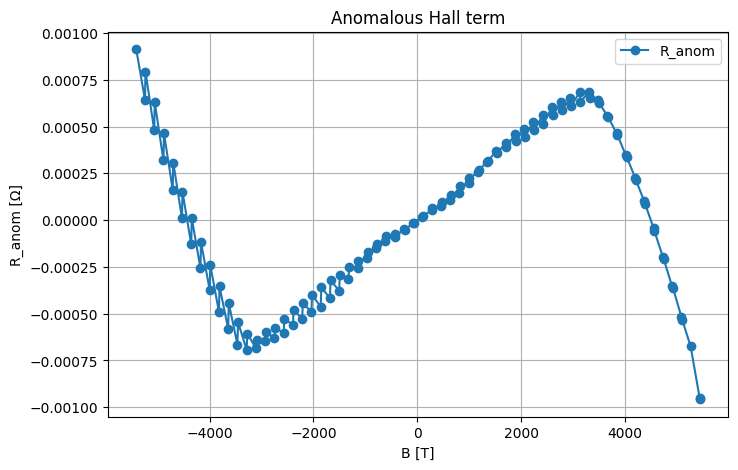

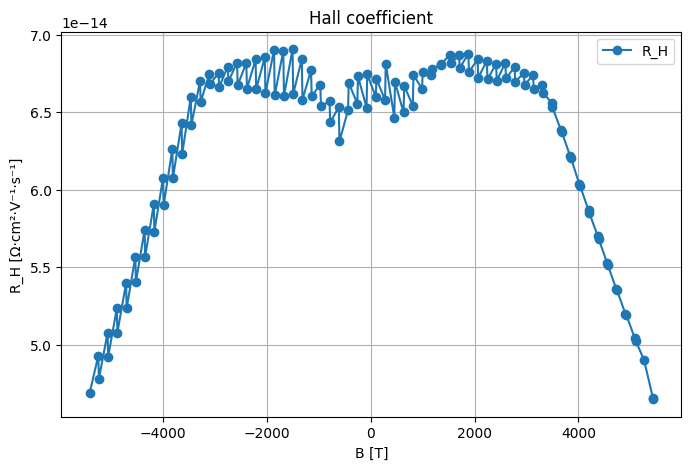

{'R0_slope': np.float64(1.052437829275943e-06), 'intercept': np.float64(8.616924579898415e-06), 'R_anom_sat': np.float64(0.0009572593413854609), 'R_AHE_sat': np.float64(0.0009572593413854609), 'R_H_avg': np.float64(6.299185073782409e-14)}


In [ ]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

def analyze_hall(data, normal_threshold=3000):
    """
    data : pandas.DataFrame with columns ["B","R"]
           B = magnetic field in Tesla
           R = measured transverse resistance in Ohm
    normal_threshold : float, |B| above this value used for normal Hall slope R0
    """

    # 依 B 排序
    df = data.sort_values("B").reset_index(drop=True)

    # 插值函數，拿來找 R(-B)
    f = interpolate.interp1d(df["B"], df["R"], kind="linear", fill_value="extrapolate")

    # 反對稱化
    B = df["B"].values
    R = df["R"].values
    R_minus = f(-B)
    R_odd = (R - R_minus) / 2.0
    df["R_odd"] = R_odd

    # ===== 正常霍爾斜率 (R0) =====
    mask_high_R0 = np.abs(B) >= normal_threshold
    if np.any(mask_high_R0):
        coeffs = np.polyfit(B[mask_high_R0], R_odd[mask_high_R0], 1)  # slope, intercept
        R0_slope, intercept = coeffs[0], coeffs[1]
    else:
        R0_slope, intercept = np.nan, np.nan

    # 扣掉正常霍爾，得到反常霍爾項
    R_anom = R_odd - (R0_slope * B)
    df["R_anom"] = R_anom

    # ===== 反常霍爾飽和電阻 =====
    R_anom_sat = np.max(np.abs(R_anom))

    # ===== 霍爾係數 R_H =====
    R_H_norm = R0_slope * 150 * 10**(-9) / (2 * math.sqrt(2)) # 厚度
    R_H = R_odd / B * 150 * 10**(-9) / (2 * math.sqrt(2))
    df["R_H"] = R_H
    R_H_avg = np.mean(R_H)

    # ===== 印出結果 =====
    print("===== 正常霍爾係數 =====")
    print(f"R_H_norm (B ≥ {normal_threshold} T): {R_H_norm:.6e} m^3 / C")

    print("===== 反常霍爾飽和電阻 =====")
    print(f"R_AHE_sat : {R_anom_sat:.6e} Ω")

    print("===== 霍爾係數 R_H =====")
    print(f"R_H_avg: {R_H_avg:.6e} m^3 / C")

    # ===== 繪圖 =====
    plt.figure(figsize=(8,5))
    plt.plot(B, R_anom, "o-", label="R_anom")
    plt.xlabel("B [T]")
    plt.ylabel("R_anom [Ω]")
    plt.title("Anomalous Hall term")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(B, R_H, "o-", label="R_H")
    plt.xlabel("B [T]")
    plt.ylabel("R_H [Ω·cm²·V⁻¹·s⁻¹]")
    plt.title("Hall coefficient")
    plt.legend()
    plt.grid(True)
    plt.show()

    return df, {
        "R0_slope": R0_slope,
        "intercept": intercept,
        "R_anom_sat": R_anom_sat,
        "R_AHE_sat": R_anom_sat,
        "R_H_avg": R_H_avg
    }


if __name__ == "__main__":
    from io import StringIO   # 放 入 數 據
    data_str = """B    R
    -5412.34	-0.07104
-5234.16	-0.07093
-5055.99	-0.07091
-4877.81	-0.07091
-4699.63	-0.07089
-4521.46	-0.07088
-4343.28	-0.07085
-4165.11	-0.07082
-3986.93	-0.07078
    """
    df = pd.read_csv(StringIO(data_str), sep=r"\s+")

    df_result, hall_results = analyze_hall(df, normal_threshold=3000)
    print(hall_results)


